<a href="https://colab.research.google.com/github/IamSVP94/test_assignments/blob/main/CV_Imagewoof_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/DLSchool/deep_learning_2018-19/blob/master/08.%20Convolutional%20Networks/%5Bseminar%5Dconvnet_pytorch.ipynb

In [1]:
!pip install fastai --upgrade
!pip install torch

In [2]:
from fastai.vision.all import URLs, untar_data

import matplotlib.pylab as plt
import albumentations as A
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

from pathlib import Path
import torch
from torch.utils.data import random_split, DataLoader, TensorDataset
import torchvision.models as models
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score

from torch.utils.data import TensorDataset, DataLoader

In [3]:
path = untar_data(URLs.IMAGEWOOF)

csv = pd.read_csv('https://raw.githubusercontent.com/fastai/imagenette/master/noisy_imagewoof.csv')
csv['path'] = [Path(path, line) for line in csv['path']]
csv = csv[['path', 'noisy_labels_0', 'is_valid']]
csv.rename(columns={'noisy_labels_0': 'label'}, inplace=True)

In [4]:
label_dict = dict(
  n02086240= 'Shih-Tzu',
  n02087394= 'Rhodesian ridgeback',
  n02088364= 'Beagle',
  n02089973= 'English foxhound',
  n02093754= 'Australian terrier',
  n02096294= 'Border terrier',
  n02099601= 'Golden retriever',
  n02105641= 'Old English sheepdog',
  n02111889= 'Samoyed',
  n02115641= 'Dingo'
)

labels = list(label_dict.keys())

In [5]:
train_csv = csv[csv['is_valid']==False]
train_csv = train_csv.sample(frac=1).reset_index(drop=True)
del train_csv['is_valid']


val_csv = csv[csv['is_valid']==True]
val_csv = val_csv.sample(frac=1).reset_index(drop=True)
del val_csv['is_valid']

test_size = int(len(val_csv)*0.1)
test_csv = val_csv[:test_size]
val_csv = val_csv[test_size:]

In [6]:
def resizer(img, df=csv, mode='original'):
    assert mode in ['original', 'train', 'val'], 'Неизвестный режим resizer'
    label = df[df['path']==img]['label'].item()
    label = label_dict[label]
    img_bgr = cv2.imread(str(img))
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)    
    if mode == 'train':
        transform = A.Compose([
            A.HorizontalFlip(p=0.5), 
            A.ShiftScaleRotate(rotate_limit=15, scale_limit=0, p=0.5), 
            A.HueSaturationValue(p=0.5),
            ], p=0.5)
        return {'img': cv2.resize(transform(image=img_rgb)['image'], (100, 100)), 'label': label}
    elif mode == 'val':
        return {'img': cv2.resize(img_rgb, (100, 100)), 'label': label}
    else:
        return {'img': img_rgb, 'label': label}

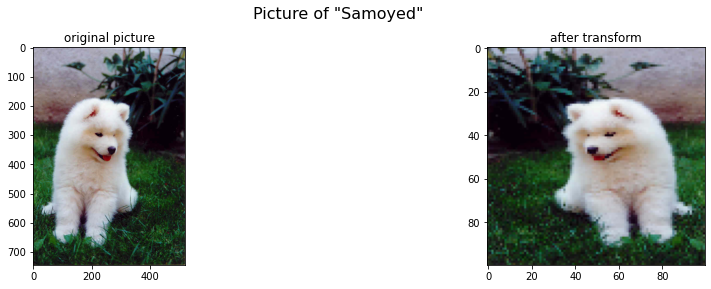

In [7]:
img = csv['path'][np.random.randint(len(csv))]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
fig.suptitle(f'Picture of "{resizer(img)["label"]}"', fontsize=16, y=1.02)
ax[0].imshow(resizer(img)['img'])
ax[1].imshow(resizer(img, mode='train')['img'])
ax[0].set_title('original picture')
ax[1].set_title('after transform');

In [8]:
torch.manual_seed(2) # for reproducibility
device = 'cuda' if torch.cuda.is_available() else 'cpu'
EPOCHS = 25
batch_size=128
start_learning_rate = 1e-2

n_classes = len(labels)

net = models.resnet34(pretrained=True).to(device)
net.fc = torch.nn.Linear(net.fc.in_features, n_classes).to(device)


criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr = start_learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, eps=1e-8, verbose=True)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [9]:
def df_to_DataLoader(df, batch_size=batch_size, mode='val'):
    imgs_list = []
    gt = []
    for i, (path, label) in tqdm(df.iterrows(), total=len(df), leave=False):
        img = resizer(path, mode=mode)["img"]
        imgs_list.append(img.reshape(3, 100, 100))
        target = labels.index(label)
        gt.append(target)
    dataset = TensorDataset(torch.Tensor(imgs_list), torch.LongTensor(gt))
    
    return DataLoader(dataset, batch_size = batch_size, shuffle = True)

In [10]:
trainloader = df_to_DataLoader(train_csv, mode='train')
valloader = df_to_DataLoader(val_csv)
testloader = df_to_DataLoader(test_csv)

  0%|          | 0/9025 [00:00<?, ?it/s]

  0%|          | 0/3537 [00:00<?, ?it/s]

  0%|          | 0/392 [00:00<?, ?it/s]

In [ ]:
torch.manual_seed(2) # for reproducibility
print('it works on', device)

train_history = []
val_history = []
loader = tqdm(range(1, EPOCHS+1), leave=True)
for epoch in loader:
    loader.set_description(f'Epoch {epoch}/{EPOCHS}')
    net.train()
    running_loss = 0
    for i, batch in enumerate(tqdm(trainloader, leave=False, colour='green', desc='training')):
        X_batch, y_batch = batch
        optimizer.zero_grad()
        y_pred = net(X_batch.to(device))
        loss = criterion(y_pred.to(device), y_batch.to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    else:
        train_history.append(running_loss/i)
    
    net.eval()
    with torch.no_grad():
        running_loss = 0
        for i, batch in enumerate(tqdm(valloader, leave=False, colour='yellow', desc='validation')):
            X_batch, y_batch = batch
            y_pred = net(X_batch.to(device))
            loss = criterion(y_pred.to(device), y_batch.to(device))
            running_loss += loss.item()
        else:
            val_history.append(running_loss/i)

    scheduler.step(val_history[-1])
    print(
        f'Epoch {epoch}/{EPOCHS}:'.ljust(12, ' '), 
        f'loss: {train_history[-1]}'.ljust(30, ' '), 
        f'val_loss: {val_history[-1]}'.ljust(30, ' '), 
        f'--> Accuracy on validation set: {round(accuracy_score(y_batch.cpu(), torch.argmax(y_pred, dim=1).cpu())*100, 4)} %'.ljust(30, ' '), 
        sep=' ', end = '\n')

it works on cpu


  0%|          | 0/25 [00:00<?, ?it/s]

training:   0%|          | 0/71 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
fig.suptitle(f'EPOCHS={EPOCHS}, start_learning_rate={start_learning_rate}, batch_size={batch_size}', fontsize=16, y=1.02)
ax[0].plot(train_history, alpha=0.8, label='Training loss')
ax[0].plot(val_history, alpha=0.8, label='Validation loss')
ax[0].set_title('Losses')
ax[1].hist((targets_t-torch.argmax(outputs_t.cpu(), dim=1)).detach().numpy(), alpha=0.8)
ax[1].hist((targets_v-torch.argmax(outputs_v.cpu(), dim=1)).detach().numpy(), alpha=0.8)
ax[1].set_title('Distribution of errors');

# пример

https://colab.research.google.com/github/walkwithfastai/walkwithfastai.github.io/blob/master/nbs/course2020/vision/04_ImageWoof.ipynb#scrollTo=IuhRnYgmYM5C

In [ ]:
items = get_image_files(path)
split_idx = GrandparentSplitter(valid_name='val')(items)

In [ ]:
lbl_dict = dict(
  n02086240= 'Shih-Tzu',
  n02087394= 'Rhodesian ridgeback',
  n02088364= 'Beagle',
  n02089973= 'English foxhound',
  n02093754= 'Australian terrier',
  n02096294= 'Border terrier',
  n02099601= 'Golden retriever',
  n02105641= 'Old English sheepdog',
  n02111889= 'Samoyed',
  n02115641= 'Dingo'
)

In [ ]:
tfms = [[PILImage.create], [parent_label, lbl_dict.__getitem__, Categorize()]]

dsets = Datasets(items, tfms, splits=split_idx)

In [ ]:
item_tfms = [ToTensor(), Resize(128)]
batch_tfms = [FlipItem(), RandomResizedCrop(128, min_scale=0.35), IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)]

dls = dsets.dataloaders(after_item=item_tfms, after_batch=batch_tfms, bs=64)

In [ ]:
dls.show_batch()